In [1]:
import numpy as np
import pandas as pd
from sklearn import *

In [2]:
COMMENT = 'comment_text'
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Problem understanding

# Dataset generation

In [ ]:
train = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv')
sample_submission = pd.read_csv('jigsaw-toxic-comment-classification-challenge/sample_submission.csv')

# Metrics define

# Validation strategy

# Data processing (extract useful information)

In [4]:
# sentiment features

from textblob import TextBlob
from multiprocess import Pool

SENTIMENT = ['polarity', 'subjectivity']
with Pool() as pool:
    train['polarity'] = pool.map(lambda text: TextBlob(text).polarity, train[COMMENT])
    train['subjectivity'] = pool.map(lambda text: TextBlob(text).subjectivity, train[COMMENT])
    test['polarity'] = pool.map(lambda text: TextBlob(text).polarity, test[COMMENT])
    test['subjectivity'] = pool.map(lambda text: TextBlob(text).subjectivity, test[COMMENT])
    

In [5]:
import re
import textwrap
import unicodedata
import warnings
from string import ascii_letters, digits, punctuation

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


class BaseFilter:
    """Base filter class, it does NOTHING.
    This class is design for providing ``__repr__`` string, which is useful in
    python interactive prompt.
    """

    def __repr__(self):
        return '<%s>' % type(self).__name__

    def __call__(self, text: str) -> str:
        return text


class GeneralFilter(BaseFilter):

    def __repr__(self):
        return '<{clsn} repl=`{repl}`>'.format(clsn=type(self).__name__,
                                               repl=self.repl)

    def __call__(self, s: str, count: int = 0):
        return self.pattern.sub(self.repl, s, count)


class EmailFilter(GeneralFilter):
    
    def __init__(self, replace=' '):
        if isinstance(replace, str):
            self.repl = replace
        else:
            self.repl = lambda match: next(replace) # for iterator tag
        self.expression = r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+'
        self.pattern = re.compile(self.expression)


class URLFilter(GeneralFilter):
    
    # copied from string_constants.py
    schemes = list(map(lambda x: '{}:\/\/'.format(x), ("http", "https", "ftp", "sftp", "irc", "magnet", "file", "data"))) + ['www.']
    schemes_lenient = list(map(lambda x: '{}:\/\/'.format(x), ("h?ttp", "h?ttps", "ftp", "sftp", "irc", "magnet", "file", "data"))) + ['www.']

    # from RFC
    gen_delims = ":/?#[]@"
    sub_delims = "!$&'()*+;=%"
    reserved = gen_delims + sub_delims
    unreserved = ascii_letters + digits + "-._~"
    valid_uri_characters = reserved + unreserved

    def __init__(self, replace=' ', allow_common_typoes=True):
        
        if isinstance(replace, str):
            self.repl = replace
        else:
            self.repl = lambda match: next(replace) # for iterator tag

        if allow_common_typoes:
            self.expression = r"((?:{})[{}]+)".format("|".join(self.schemes), re.escape(self.valid_uri_characters))
        else:
            self.expression = r"((?:{})[{}]+)".format("|".join(self.schemes_lenient), re.escape(self.valid_uri_characters))
        self.pattern = re.compile(self.expression)


class EscapeCharFilter(GeneralFilter):

    def __init__(self, replace:str=' '):
        self.repl = replace
        self.expression = r'([{}])'.format('\r\n\t\v')
        self.pattern = re.compile(self.expression)


class InvisableCharFilter(GeneralFilter):
    
    def __init__(self, replace:str='', ):
        self.repl = replace
        self.expression = r'([{}])'.format(r'\xa0\xad\u200c')
        self.pattern = re.compile(self.expression)


class KeyWordsFilter(GeneralFilter):
    
    def __init__(self, replace:str=' ', keywords=('mailto',)):
        self.repl = replace
        self.expression = r'({})'.format('|'.join(map(lambda x: '({})'.format(x), keywords)))
        self.pattern = re.compile(self.expression)


class MultiSpacesFilter(GeneralFilter):
    
    def __init__(self, replace:str=' '):
        self.repl = replace
        self.expression = r'(\s+)'
        self.pattern = re.compile(self.expression)


class FilterNonChars(GeneralFilter):

    def __init__(self, replace:str=' '):
        self.repl = replace
        self.expression = r'(\W+)'
        self.pattern = re.compile(self.expression)
        
        
class HTMLFilter(GeneralFilter):
    def __init__(self, replace:str=''):
        self.repl = replace
        self.expression = "<[^>]*>"
        self.pattern = re.compile(self.expression)

class HTML2Text:
    
    def __init__(self, filters=('script', 'style', 'meta', 'noscript')):
        self.filters = filters

    def extract_text_from_html(self, html:str):

        soup = BeautifulSoup(html, features='lxml')
        for script in soup(self.filters): # remove all javascript and stylesheet code
            script.decompose()
        return soup.get_text()
    
    def __call__(self, html:str):
        try:
            return self.extract_text_from_html(html)
        except:
            return str()



class UnicodeStandarizer:
    
    def __init__(self, method='NFKC'): # NFD, NFC, NFKD, NFKC
        self.method = method
    
    def __call__(self, text:str):
        return unicodedata.normalize(self.method, text)


class Stripper:
    @staticmethod    
    def __call__(text:str):
        return text.strip()


class Lowercasting:
    @staticmethod    
    def __call__(text:str):
        return text.lower()


class SequentialProcessor(BaseFilter):
    """Sequential processor: A class provide an interface to create integral
    processor that would sequentially filter text by the given filters.
    Usage::
        text_preprocessor = SequentialProcessor(
            UnicodeStandarizer(),
            HTML2Text(),
            InvisableCharFilter(),
            LIDFilter(),
            Lowercasting(),
            KeyWordsFilter(),
            MultiSpacesFilter(),
            Stripper(),
        )
    """

    def __init__(self, *processors):
        self.pipeline = processors

    def __repr__(self):
        if len(self.pipeline) == 1:
            children_desc = repr(self.pipeline)
        else:
            # use textwrap to support nested processors
            children_desc = '\n' + ',\n'.join(
                textwrap.indent(repr(p), ' ' * 4)
                for p in self.pipeline)
        return '<{clsn} [{child}]>'.format(clsn=type(self).__name__,
                                           child=children_desc)

    def __call__(self, text: str):
        for processor in self.pipeline:
            text = processor(text)
        return text

class GeneralProcessor(SequentialProcessor):
    pass

class KeepWordSpace(GeneralFilter):
    def __init__(self, replace:str=' '):
        self.repl = replace
        self.expression = r'([^\w\s])'
        self.pattern = re.compile(self.expression)
        
class WordModelPreprocessor(GeneralProcessor):
    
    def __init__(self):
        self.pipeline = (UnicodeStandarizer(), HTML2Text(), URLFilter(), EscapeCharFilter(), KeepWordSpace(), Lowercasting(), MultiSpacesFilter(), Stripper())

class LIDFilter(GeneralFilter):
    
    def __init__(self, replace=' '):
        self.repl = replace
        filters = EmailFilter(), URLFilter(), EscapeCharFilter(), FilterNonChars()
        self.expression = '|'.join(list(map(lambda x: x.expression, filters)))
        self.pattern = re.compile(self.expression)

class TextPreprocessor(GeneralProcessor):
    
    def __init__(self):
        self.pipeline = (UnicodeStandarizer(), HTML2Text(), InvisableCharFilter(), LIDFilter(), Lowercasting(), KeyWordsFilter(), MultiSpacesFilter(), Stripper())

In [6]:
class TextPreprocessor(GeneralProcessor):
    
    def __init__(self):
        self.pipeline = (UnicodeStandarizer(), HTML2Text(), URLFilter(), EmailFilter(), InvisableCharFilter(), LIDFilter(), Lowercasting(), KeyWordsFilter(), MultiSpacesFilter(), Stripper())

In [7]:
text_preprocessor = TextPreprocessor()
with Pool() as pool:
    train[COMMENT] = pool.map(text_preprocessor, train[COMMENT])
    test[COMMENT] = pool.map(text_preprocessor, test[COMMENT])

# Data understanding & visualization

# De-noise (no drop data)

# Feature engineering

In [8]:
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_features=16384)

x_train = vec.fit_transform(train[COMMENT])
x_test = vec.transform(test[COMMENT])

In [27]:
x_train_sentiment = sparse.hstack([x_train, train['polarity'].values.reshape(-1, 1), train['subjectivity'].values.reshape(-1, 1)])
x_test_sentiment = sparse.hstack([x_test, test['polarity'].values.reshape(-1, 1), test['subjectivity'].values.reshape(-1, 1)])

In [33]:
x_train_sentiment.shape

(159571, 16386)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

x_train_char = vec.fit_transform(train[COMMENT])
x_test_char = vec.transform(test[COMMENT])

In [30]:
x_train_char_sentiment = sparse.hstack([x_train_char, train['polarity'].values.reshape(-1, 1), train['subjectivity'].values.reshape(-1, 1)])
x_test_char_sentiment = sparse.hstack([x_test_char, test['polarity'].values.reshape(-1, 1), test['subjectivity'].values.reshape(-1, 1)])

In [32]:
x_train_char_sentiment.shape

(159571, 262191)

# Offline augmentation

# Standarization

# Scaling

# Normalization

# Feature selection

# Data selection

# Optimization

In [28]:
# baseline model with preprocess & sentiment appended.

from sklearn.linear_model import LogisticRegression
models = {l: LogisticRegression(n_jobs=-1) for l in LABELS}
[models[l].fit(x_train_sentiment, train[l]) for l in LABELS]
for l in LABELS:
    sample_submission[l] = models[l].predict_proba(x_test_sentiment)[:, 1]
sample_submission.to_csv('submission.csv', index=False)

# ~ 97.37% (worse)

# NOTE:
#     would the model be too linear to leverage sentiment feature? or too little dimention sentiment represents?

/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
# baseline model with preprocess, 2-4 char grams & sentiment appended.

from sklearn.linear_model import LogisticRegression
models = {l: LogisticRegression(n_jobs=-1) for l in LABELS}
[models[l].fit(x_train_char_sentiment, train[l]) for l in LABELS]
for l in LABELS:
    sample_submission[l] = models[l].predict_proba(x_test_char_sentiment)[:, 1]
sample_submission.to_csv('submission.csv', index=False)

# ~ 97.49%

/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
# baseline model with preprocess, 2-4 char grams & sentiment appended, weaker regularization.

from sklearn.linear_model import LogisticRegression
models = {l: LogisticRegression(C=3, n_jobs=-1) for l in LABELS}
[models[l].fit(x_train_char_sentiment, train[l]) for l in LABELS]
for l in LABELS:
    sample_submission[l] = models[l].predict_proba(x_test_char_sentiment)[:, 1]
sample_submission.to_csv('submission.csv', index= False)

# ~ 97.59%

/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [51]:
# baseline model with preprocess, 2-4 char grams & sentiment appended, weaker regularization.

from sklearn.linear_model import LogisticRegression
models = {l: LogisticRegression(C=3, n_jobs=-1, solver='saga') for l in LABELS}
[models[l].fit(x_train_char_sentiment, train[l]) for l in LABELS]
for l in LABELS:
    sample_submission[l] = models[l].predict_proba(x_test_char_sentiment)[:, 1]
sample_submission.to_csv('submission.csv', index=False)

# ~ 97.58%

/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [50]:
# baseline model with preprocess, 2-4 char grams & sentiment appended, weaker regularization.

from sklearn.linear_model import LogisticRegression
models = {l: LogisticRegression(C=100, n_jobs=-1) for l in LABELS}
[models[l].fit(x_train_char_sentiment, train[l]) for l in LABELS]
for l in LABELS:
    sample_submission[l] = models[l].predict_proba(x_test_char_sentiment)[:, 1]
sample_submission.to_csv('submission.csv', index=False)

# 96.25%

# Parameter tuning

# Online augmentation

# Model selection / blending

# Post-processing

# Evaluation

# Reasoning

In [75]:
l = LABELS[0]

y_train_pred = models[l].predict(x_train_char_sentiment)
y_test_pred  = models[l].predict(x_test_char_sentiment)

train['toxic_pred'] = y_train_pred
test['toxic_pred'] = y_test_pred

y_train = train[l]
y_test = test_labels[l]

x = train[y_train_pred != y_train][['comment_text', 'toxic', 'toxic_pred']]
fp = x[x['toxic']==0]
fn = x[x['toxic']==1]

In [79]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

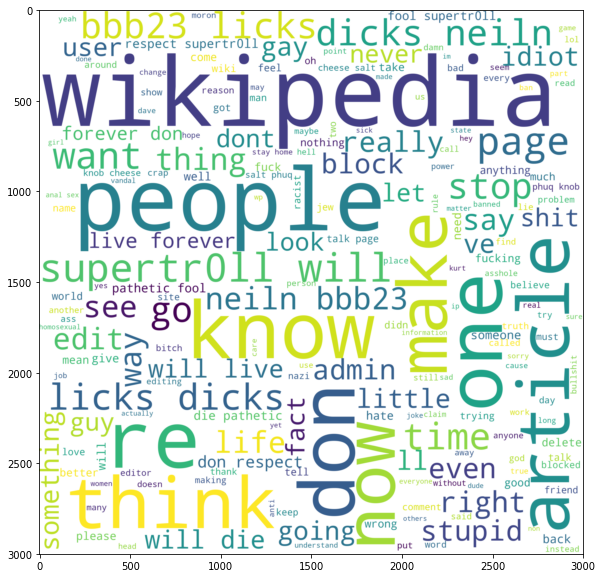

In [80]:
text = ' '.join(fp[COMMENT]).lower()
wordcloud = WordCloud(background_color="white",width=3000, height=3000, margin=1).generate(text)
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation='bilinear')

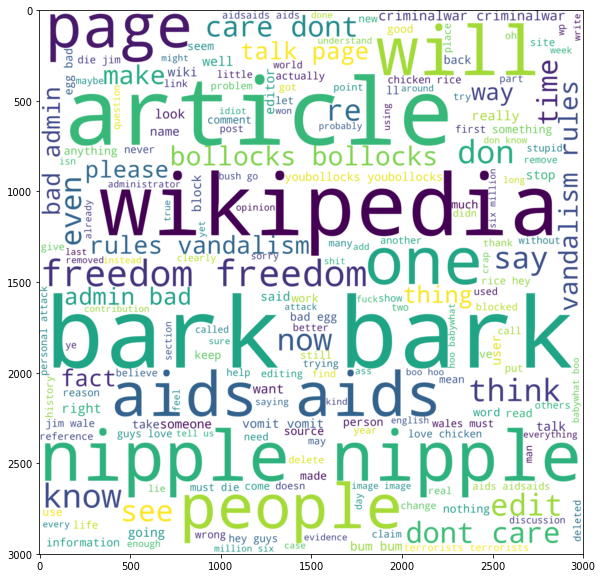

In [81]:
text = ' '.join(fn[COMMENT]).lower()
wordcloud = WordCloud(background_color="white",width=3000, height=3000, margin=1).generate(text)
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation='bilinear')

In [86]:
from itertools import product
import seaborn as sns

In [89]:
SENTIMENT = ['polarity', 'subjectivity']
with Pool() as pool:
    fp['polarity'] = pool.map(lambda text: TextBlob(text).polarity, fp[COMMENT])
    fp['subjectivity'] = pool.map(lambda text: TextBlob(text).subjectivity, fp[COMMENT])
    fn['polarity'] = pool.map(lambda text: TextBlob(text).polarity, fn[COMMENT])
    fn['subjectivity'] = pool.map(lambda text: TextBlob(text).subjectivity, fn[COMMENT])
# sns.jointplot(x="polarity", y="subjectivity", data=train, size=10, kind='reg');

/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

toxic polarity


/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/shanger_lin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


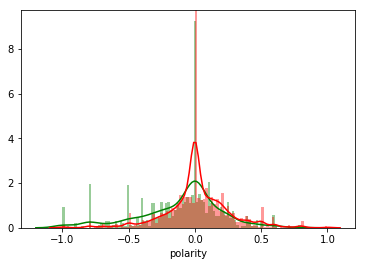

toxic subjectivity


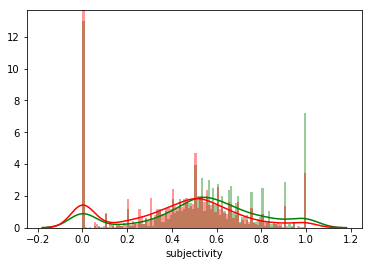

<Figure size 432x288 with 0 Axes>

In [92]:
for sentiment, toxic_type  in product(SENTIMENT, ['toxic']):
    print(toxic_type, sentiment)
    sns.distplot(fp[train[toxic_type]==0][sentiment], color="g", bins=100, label='negative')
    sns.distplot(fn[train[toxic_type]==1][sentiment], color="r", bins=100, label='positive')
    plt.show()
    plt.clf()  

# Monitoring